In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import h5py

print(plt.isinteractive())

True


Number of ELMs: 4290
Number of ELMs for analysis: 200
delt (ms):  min 9.40  q5 16.32 med 29.87 q95 79.85 max 123.68
Ip (MA):  min 0.91  q5 1.01  med 1.15  q95 1.70  max 2.00 
Bt (T):  min -2.32 q5 -2.25 med -2.15 q95 -1.99 max -1.81


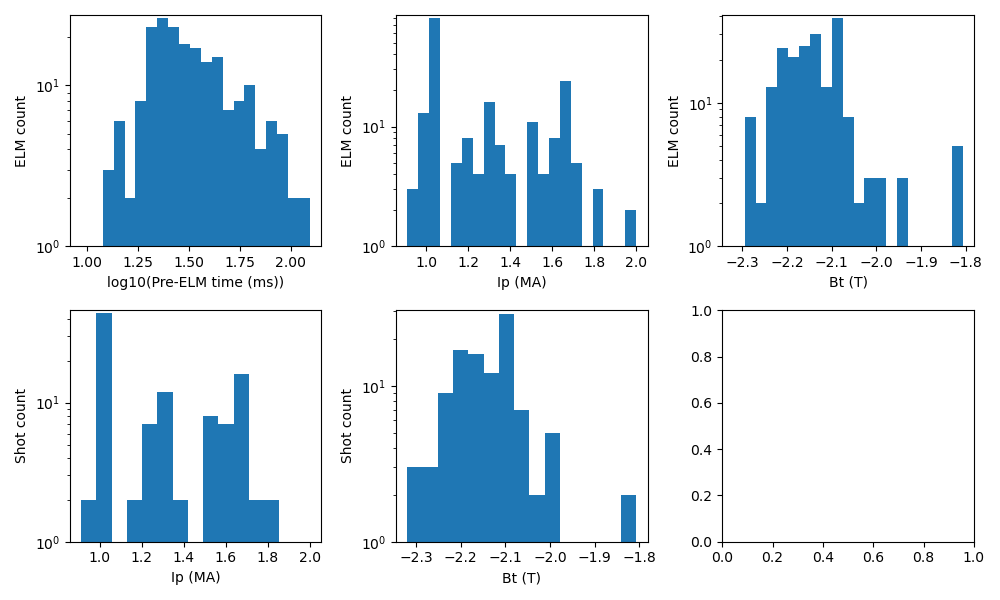

In [2]:
plt.close('all')

elm_data_file = '/home/smithdr/ml/elm_data/step_6_labeled_elm_data/elm_data_v1.hdf5'
max_elms = 200

def vector_stats(vector:np.ndarray):
    quants = np.quantile(vector, [0.05,0.95])
    output = f"min {vector.min():<5.2f} q5 {quants[0]:<5.2f} med {np.median(vector):<5.2f} q95 {quants[1]:<5.2f} max {np.max(vector):<5.2f}"
    return output

with h5py.File(elm_data_file, 'r') as root:
    elms = root['elms']
    n_elms = len(elms)
    print(f"Number of ELMs: {n_elms}")
    n_elms = n_elms if max_elms is None else max_elms
    print(f"Number of ELMs for analysis: {n_elms}")
    delt = np.empty(n_elms) * np.nan
    elm_ip = np.empty(n_elms) * np.nan
    elm_bt = np.empty(n_elms) * np.nan
    shot_ip = {}
    shot_bt = {}
    elm_avg = np.empty((64, n_elms)) * np.nan
    elm_std = np.empty((64, n_elms)) * np.nan
    elm_min = np.empty((64, n_elms)) * np.nan
    elm_max = np.empty((64, n_elms)) * np.nan
    elm_keys = list(elms.keys())
    rng = np.random.default_rng()
    if max_elms:
        rng.shuffle(elm_keys)
    for i_elm, elm_key in enumerate(elm_keys):
        if max_elms and i_elm==max_elms:
            break
        elm = elms[elm_key]
        shot = root['shots'][str(elm.attrs['shot'])]
        assert shot.attrs['ip_pos_phi']==True and shot.attrs['bt_pos_phi']==False, f"{i_elm}"
        shot_ip[elm.attrs['shot']] = shot.attrs['ip_extremum']
        shot_bt[elm.attrs['shot']] = shot.attrs['bt_extremum']
        elm_ip[i_elm] = shot.attrs['ip_extremum']
        elm_bt[i_elm] = shot.attrs['bt_extremum']
        delt[i_elm] = elm.attrs['t_stop'] - elm.attrs['t_start']
        t_mid = elm.attrs['t_start'] + delt[i_elm]/2
        i_start = np.nonzero(elm['bes_time'] >= elm.attrs['t_start'])[0][0]
        i_stop = np.nonzero(elm['bes_time'] > elm.attrs['t_stop'])[0][0]
        assert i_stop-i_start > 8000
        i_mid = (i_start+i_stop) // 2
        # channel_windows = elm['bes_signals'][:, i_mid-500:i_mid+500]
        elm_avg[:, i_elm] = 0  # np.mean(channel_windows, axis=1)
        elm_std[:, i_elm] = 0  # np.std(channel_windows, axis=1)
        elm_min[:, i_elm] = 0  # np.min(channel_windows, axis=1)
        elm_max[:, i_elm] = 0  # np.max(channel_windows, axis=1)
        # if i_elm==0:
        #     print(elm.attrs.keys())
        #     print(elm.keys())
        #     print(shot.attrs.keys())
        #     print(shot.attrs['ip_pos_phi'], shot.attrs['bt_pos_phi'])


for ndarray in [delt, elm_ip, elm_bt, elm_avg, elm_std, elm_min, elm_max]:
    assert np.all(np.isfinite(ndarray))

print(f"delt (ms):  {vector_stats(delt)}")
print(f"Ip (MA):  {vector_stats(elm_ip/1e6)}")
print(f"Bt (T):  {vector_stats(elm_bt)}")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
plt.sca(axes.flat[0])
plt.hist(np.log10(delt), bins=21)
plt.xlabel('log10(Pre-ELM time (ms))')
plt.ylabel('ELM count')
plt.ylim([1,None])
plt.yscale('log')

plt.sca(axes.flat[1])
plt.hist(elm_ip/1e6, bins=21)
plt.xlabel('Ip (MA)')
plt.ylabel('ELM count')
plt.ylim([1,None])
plt.yscale('log')

plt.sca(axes.flat[2])
plt.hist(elm_bt, bins=21)
plt.xlabel('Bt (T)')
plt.ylabel('ELM count')
plt.ylim([1,None])
plt.yscale('log')

plt.sca(axes.flat[3])
plt.hist([val/1e6 for val in shot_ip.values()], bins=15)
plt.xlabel('Ip (MA)')
plt.ylabel('Shot count')
plt.ylim([1,None])
plt.yscale('log')

plt.sca(axes.flat[4])
plt.hist([val for val in shot_bt.values()], bins=15)
plt.xlabel('Bt (T)')
plt.ylabel('Shot count')
plt.ylim([1,None])
plt.yscale('log')

plt.tight_layout()
